<a href="https://colab.research.google.com/github/ali-kmirzaei/NN-and-DL/blob/main/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs and Drive

In [ ]:
!pip install livelossplot

In [ ]:
!apt install tree

In [89]:
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os
from livelossplot import PlotLossesKeras

from tensorflow.keras.optimizers import Adam

import cv2 as cv
from tensorflow.keras.models import Sequential #FeedForward
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import random


In [ ]:
# import dataset from google drive
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
# !rm -rf datasets
!unzip /mydrive/lol_dataset.zip -d datasets

In [7]:
!mv datasets/lol_dataset/eval15/ datasets/
!mv datasets/lol_dataset/our485/ datasets/
!rm -rf datasets/lol_dataset

# Create Dataset

In [ ]:
!tree datasets

In [66]:
# Train Dataset
SIZE = 150
train_inputs = list()
train_outputs = list()

path = 'datasets/our485/low'
for item in os.listdir(path):
  if '.png' in item:
    img = plt.imread(os.path.join(path, item))
    img = cv.resize(img, (SIZE, SIZE))
    train_inputs.append(img)

path = 'datasets/our485/high'
for item in os.listdir(path):
  if '.png' in item:
    img = plt.imread(os.path.join(path, item))
    img = cv.resize(img, (SIZE, SIZE))
    train_outputs.append(img)

train_inputs = np.array(train_inputs)
train_outputs = np.array(train_outputs)

print(train_inputs.shape, train_outputs.shape)

(485, 150, 150, 3) (485, 150, 150, 3)


In [67]:
# Test Dataset
SIZE = 150
test_inputs = list()
test_outputs = list()

path = 'datasets/eval15/low'
for item in os.listdir(path):
  if '.png' in item:
    img = plt.imread(os.path.join(path, item))
    img = cv.resize(img, (SIZE, SIZE))
    test_inputs.append(img)

path = 'datasets/eval15/high'
for item in os.listdir(path):
  if '.png' in item:
    img = plt.imread(os.path.join(path, item))
    img = cv.resize(img, (SIZE, SIZE))
    test_outputs.append(img)

test_inputs = np.array(test_inputs)
test_outputs = np.array(test_outputs)

print(test_inputs.shape, test_outputs.shape)

(15, 150, 150, 3) (15, 150, 150, 3)


In [ ]:
plt.imshow(test_outputs[0])

In [46]:
train_inputs = train_inputs.astype('float32')
train_outputs = train_outputs.astype('float32')

test_inputs = test_inputs.astype('float32')
test_outputs = test_outputs.astype('float32')

In [5]:
train_inputs = train_inputs.astype('float32') / 255.
train_outputs = train_outputs.astype('float32') / 255.

test_inputs = test_inputs.astype('float32') / 255.
test_outputs = test_outputs.astype('float32') / 255.

In [80]:
# tmp = train_inputs.reshape((len(train_inputs), np.prod(train_inputs.shape[1:])))
# print(train_inputs.shape)

(485, 67500)


# **Simple AutoEncoder**

In [69]:
train_inputs_tmp = train_inputs.reshape((len(train_inputs), np.prod(train_inputs.shape[1:])))
train_outputs_tmp = train_outputs.reshape((len(train_outputs), np.prod(train_outputs.shape[1:])))

test_inputs_tmp  = test_inputs.reshape((len(test_inputs), np.prod(test_inputs.shape[1:])))
test_outputs_tmp  = test_outputs.reshape((len(test_outputs), np.prod(test_outputs.shape[1:])))

In [70]:
EPOCHS = 15
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.3

In [ ]:
encoding_dim = 15 
input_img = Input(shape=(67500,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(67500, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(train_inputs_tmp, train_outputs_tmp, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

# RESULT IS: loss: 0.4512 - val_loss: 0.4280

In [ ]:
encoded_img = encoder.predict(test_inputs_tmp)
decoded_img = decoder.predict(encoded_img)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_inputs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_img[i].reshape(SIZE, SIZE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# CNN AE

In [68]:
train_inputs.shape

(485, 150, 150, 3)

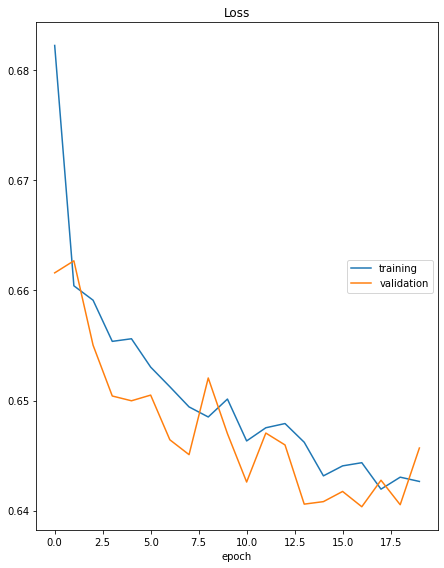

Loss
	training         	 (min:    0.642, max:    0.682, cur:    0.643)
	validation       	 (min:    0.640, max:    0.663, cur:    0.646)


In [90]:
EPOCHS = 20
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.3
LEARNING_RATE = 0.01

model = Sequential()
model.add(Input((150,150,3)))
# encoder network
model.add(Conv2D(16, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))
# decoder network
model.add(Conv2D(16, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
# output layer
model.add(Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding= 'same'))

OPT = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=OPT, loss='binary_crossentropy')
print(model.summary())
model.fit(train_inputs, train_outputs, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[PlotLossesKeras()], verbose=0)

# ------------------------------------------------------------------------------
# Results-Note!
# Loss
	# training         	 (min:    0.642, max:    0.682, cur:    0.643)
	# validation       	 (min:    0.640, max:    0.663, cur:    0.646)

# PSNRs

In [91]:
# Between 2 images from test set (test in. and test out.)
psnrs = tf.image.psnr(test_inputs[0], test_outputs[0], max_val=1.0)
print(psnrs)

tf.Tensor(5.0960226, shape=(), dtype=float32)


In [110]:
# Between 2 sets (train in. and train out.)
psnrs = tf.image.psnr(train_inputs, train_outputs, max_val=255)
print(np.mean(psnrs))

55.893166


In [93]:
# Between 2 sets (test in. and test out.)
psnrs = tf.image.psnr(test_inputs, test_outputs, max_val=255)
print(np.mean(psnrs))

55.928005


In [94]:
# Between 2 sets (preds and train set)
preds = model.predict(train_inputs)
psnrs = tf.image.psnr(preds, train_outputs, max_val=255)
print(np.mean(psnrs))

64.90388


In [95]:
# Between 2 sets (preds and test set)
preds = model.predict(test_inputs)
psnrs = tf.image.psnr(preds, test_outputs, max_val=255)
print(np.mean(psnrs))

64.920204


In [96]:
# Between 2 images from preds and test set
psnrs = tf.image.psnr(preds[0], test_outputs[0], max_val=255)
print(psnrs)

tf.Tensor(64.365204, shape=(), dtype=float32)


# Some Displays

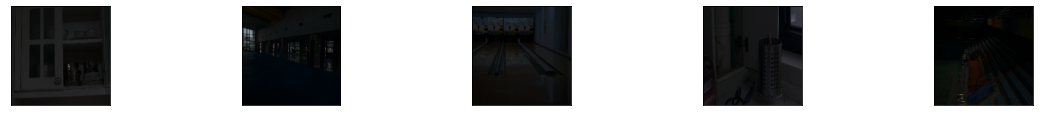

In [107]:
# Display test_input
plt.figure(figsize=(20, 4))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_inputs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

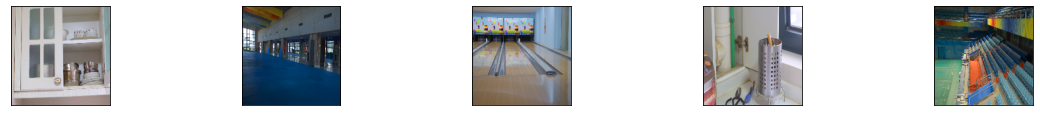

In [111]:
# Display test_output
plt.figure(figsize=(20, 4))
for i in range(5):  
  ax = plt.subplot(2, 5, i + 1 + 5)
  plt.imshow(test_outputs[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

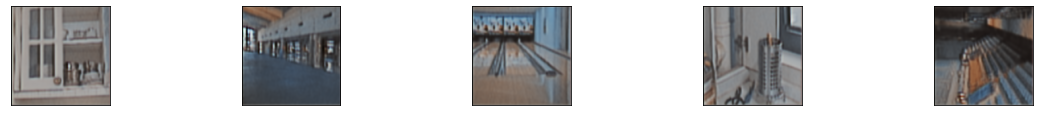

In [108]:
# Display preds
plt.figure(figsize=(20, 4))
for i in range(5):
  ax = plt.subplot(2, 5, i + 1 + 5)
  plt.imshow(preds[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()